# Functional Encryption - Classification and information leakage


## Purpose

We do like part 4 except we put a public network over the private output not only for the collateral task but also for main one.

Actually, we also provide more epochs for the main task to train as this training is fast and more epochs are required when the model gets deeper. The model isn't deeper for the collateral task so we don't have to increase the number of epochs there.

More over, we provide a parameter `PRIVATE_OUTPUT_SIZE = 26` which controls the size of the private output, as this doesn't need anymore to be 26 for we have another public network on top of it. For now we leave it to 26.


# 3 Collateral Learning


We will use the code directly from the repo, to make the notebook more readable. Functions are similar to those presented earlier.

In [1]:
# Allow to load packages from parent
import sys, os
sys.path.insert(1, os.path.realpath(os.path.pardir))

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import learn
from learn import main, train, test, show_results, show_confusion_matrix

## 3.1 Loading the quadratic baseline
Let's train the baseline model and this how we can use its output to train a "adversarial/collateral" network!

In [3]:
PRIVATE_OUTPUT_SIZE = 26
N_CHARS = 26

class QuadNet(nn.Module):
    def __init__(self):
        super(QuadNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, PRIVATE_OUTPUT_SIZE)
        
        # --- FFN for characters
        self.lin1 = nn.Linear(PRIVATE_OUTPUT_SIZE, 16)
        self.lin2 = nn.Linear(16, N_CHARS)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return F.log_softmax(x, dim=1)
    
    def transform(self, x):
        """Same as forward but without the log_softmax"""
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x

In [4]:
results = {}
quad_model = QuadNet()
results[f'Main task {PRIVATE_OUTPUT_SIZE}'], model, pred_labels = main(model=quad_model, epochs=20, model_type='quad', task='char', return_model=True, return_pred_label=True)


Training set 60000 items
Testing set  10000 items
Learning on char with quad 
Train Epoch: 1 [0/60000 (0%)]	Loss: 3.389418
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.225192
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.104812
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.117243

Test set: Average loss: 0.6908, Accuracy: 7785/10000 (77.85%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.022729
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.697004
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.688055
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.468081

Test set: Average loss: 0.4380, Accuracy: 8616/10000 (86.16%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.638604
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.554180
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.312565
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.361070

Test set: Average loss: 0.3730, Accuracy: 8807/10000 (88.07%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.491259
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.455272
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.448896


We save the model so that we won't have to train it again. _Make sure have the correct path and directories._

In [5]:
torch.save(model.state_dict(), '../data/models/quad_char.pt')

Let's also show the confusion matrix

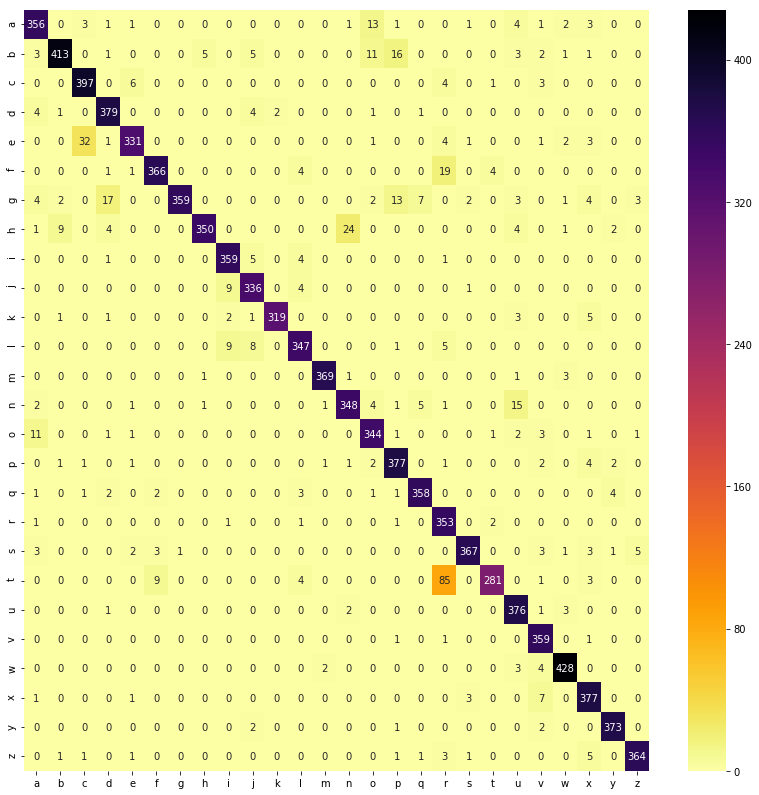

In [6]:
show_confusion_matrix(pred_labels, task='char')

## 2.2 Setting up the adversarial task

We will now use the output of the trained baseline model which is freezed as an input of another model called the `adversarial_model` which will try to predict on another task, namely the family recognition

There are little change compared to the usual test, train and main functions.

In [7]:
def adversarial_train(args, adversarial_model, model, train_loader, adv_optimizer, epoch):
    adversarial_model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data = model.transform(data)  # <-- This is new
        adv_optimizer.zero_grad()
        output = adversarial_model(data)
        loss = F.nll_loss(output, target)

        loss.backward()
        adv_optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item()))


def adversarial_test(args, adversarial_model, model, test_loader):
    adversarial_model.eval()
    test_loss = 0
    correct = 0
    pred_labels = None
    with torch.no_grad():
        for data, target in test_loader:
            data = model.transform(data) # <-- This is new
            output = adversarial_model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            pred_labels_batch = torch.stack((pred, target.view_as(pred))).view(2, args.test_batch_size)
            if pred_labels is None:
                pred_labels = pred_labels_batch
            else:
                pred_labels = torch.cat((pred_labels, pred_labels_batch), dim=1).view(2, -1)

    test_loss /= len(test_loader.dataset)

    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), acc))
    
    return acc, pred_labels.transpose(0, 1)


This is the Adversarial model that we will use. We use the same CNN structure as seen previously.

In [8]:
class AdversarialCNN(nn.Module):
    def __init__(self, output_size):
        super(AdversarialCNN, self).__init__()
        self.lin1 = nn.Linear(PRIVATE_OUTPUT_SIZE, 784)
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, output_size)

    def forward(self, x):
        x = self.lin1(x)
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [9]:
import torch.optim as optim
import torch.utils.data as utils

class Parser:
    def __init__(self):
        self.epochs = 10
        self.lr = 0.01
        self.momentum = 0.5
        self.seed = 1
        self.test_batch_size = 1000
        self.batch_size = 64
        self.no_cuda = False
        self.save_model = False
        self.log_interval = 300
        
def build_tensor_dataset(data, target):
    normed_data = [(d - d.mean()) / d.std() for d in data]
    normed_data = torch.stack([torch.Tensor(d).reshape(1, 28, 28) for d in normed_data])
    target = torch.LongTensor([i[0] for i in target])
    tensor_dataset = utils.TensorDataset(normed_data, target)
    return tensor_dataset
    

The base quadratic model is already trained to detect char, which it does not to badly.
We compute explicitely the weight sum of the quadratic model parameters to verify that this private model is left unchanged after the collateral learning phase.

In [10]:
quad_param_norm = quad_model.proj1.weight.norm() + quad_model.diag1.weight.norm()
quad_param_norm

tensor(6.9117, grad_fn=<AddBackward0>)

We new try to detect using its output, the family of the original input data.

In [11]:
data = learn.load_data()
train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data

Training set 60000 items
Testing set  10000 items


In [12]:
def adversarial_phase(model):
    args = Parser()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    # setting = the family recognition task
    train_dataset = build_tensor_dataset(train_data, train_target_family)
    test_dataset = build_tensor_dataset(test_data, test_target_family)
    adversarial_output_size = 5
    
    train_loader = utils.DataLoader(
        train_dataset,
        batch_size=args.batch_size, shuffle=True
    )
    
    test_loader = utils.DataLoader(
        test_dataset,
        batch_size=args.test_batch_size, shuffle=True
    )
    
    adversarial_model = AdversarialCNN(output_size=adversarial_output_size)
    adversarial_optimizer = optim.SGD(adversarial_model.parameters(), lr=args.lr, momentum=args.momentum)
    
    test_perfs = []
    for epoch in range(1, args.epochs + 1):
        adversarial_train(args, adversarial_model, model, train_loader, adversarial_optimizer, epoch)
        acc, pred_labels = adversarial_test(args, adversarial_model, model, test_loader)
        test_perfs.append(acc)
        
    return test_perfs, pred_labels
        


In [13]:
test_perfs, pred_labels = adversarial_phase(quad_model)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.595753
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.163675
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.944110
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.830611

Test set: Average loss: 0.7997, Accuracy: 6787/10000 (67.87%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.797236
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.688284
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.643369
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.774491

Test set: Average loss: 0.7076, Accuracy: 7105/10000 (71.05%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.671685
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.707356
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.429201
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.520492

Test set: Average loss: 0.6325, Accuracy: 7460/10000 (74.60%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.676796
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.516792
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.716143
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.519480

Test set: Average loss: 0.6

The learning curve:

In [14]:
collateral_accuracy = {}
collateral_accuracy[f'Private output size = {PRIVATE_OUTPUT_SIZE}'] = test_perfs

### Discussion

First, let's verify that the private model weights have not changed

In [15]:
assert quad_param_norm == quad_model.proj1.weight.norm() + quad_model.diag1.weight.norm()

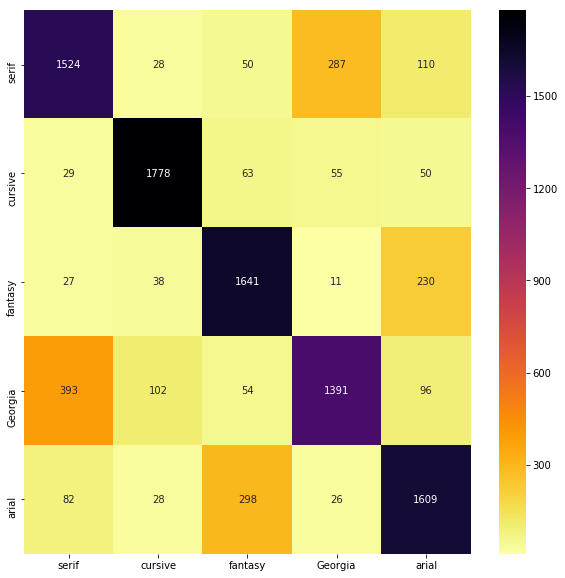

In [16]:
show_confusion_matrix(pred_labels, task='family')

You shouldn't observe much difference, except that we lost a bit of accuracy for the collateral task, around 3%.

We now change the output of the private network to see how the main and collateral accuracy degrade.

### Changing the private output size

In [17]:
PRIVATE_OUTPUT_SIZE = 8
N_CHARS = 26

class QuadNet(nn.Module):
    def __init__(self):
        super(QuadNet, self).__init__()
        self.proj1 = nn.Linear(784, 50)
        self.diag1 = nn.Linear(50, PRIVATE_OUTPUT_SIZE)
        
        # --- FFN for characters
        self.lin1 = nn.Linear(PRIVATE_OUTPUT_SIZE, 16)
        self.lin2 = nn.Linear(16, N_CHARS)

    def forward(self, x):
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        
        x = F.relu(self.lin1(x))
        x = self.lin2(x)
        return F.log_softmax(x, dim=1)
    
    def transform(self, x):
        """Same as forward but without the log_softmax"""
        x = x.view(-1, 784)
        x = self.proj1(x)
        x = x * x
        x = self.diag1(x)
        return x

In [18]:
quad_model = QuadNet()
results[f'Main task {PRIVATE_OUTPUT_SIZE}'], model, pred_labels = main(model=quad_model, epochs=20, model_type='quad', task='char', return_model=True, return_pred_label=True)


Training set 60000 items
Testing set  10000 items
Learning on char with quad 
Train Epoch: 1 [0/60000 (0%)]	Loss: 3.410638
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.004164
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.052036
Train Epoch: 1 [57600/60000 (96%)]	Loss: 1.066432

Test set: Average loss: 0.7880, Accuracy: 7441/10000 (74.41%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.213897
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.819570
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.582644
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.517671

Test set: Average loss: 0.5126, Accuracy: 8422/10000 (84.22%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.799727
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.517046
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.285547
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.294108

Test set: Average loss: 0.3745, Accuracy: 8804/10000 (88.04%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.466734
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.601342
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.446483


In [19]:
torch.save(model.state_dict(), '../data/models/quad_char.pt')

In [20]:
class AdversarialCNN(nn.Module):
    def __init__(self, output_size):
        super(AdversarialCNN, self).__init__()
        self.lin1 = nn.Linear(PRIVATE_OUTPUT_SIZE, 784)
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, output_size)

    def forward(self, x):
        x = self.lin1(x)
        x = x.view(-1, 1, 28, 28)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [21]:
data = learn.load_data()
train_data, train_target_char, train_target_family, test_data, test_target_char, test_target_family = data

Training set 60000 items
Testing set  10000 items


In [22]:
test_perfs, pred_labels = adversarial_phase(quad_model)
collateral_accuracy[f'Private output size = {PRIVATE_OUTPUT_SIZE}'] = test_perfs

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.691287
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.047301
Train Epoch: 1 [38400/60000 (64%)]	Loss: 1.102217
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.746538

Test set: Average loss: 1.1065, Accuracy: 5497/10000 (54.97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.043540
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.767199
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.800712
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.928212

Test set: Average loss: 0.8962, Accuracy: 6377/10000 (63.77%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.807289
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.912607
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.765694
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.017401

Test set: Average loss: 0.8197, Accuracy: 6647/10000 (66.47%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.785150
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.803270
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.828787
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.847577

Test set: Average loss: 0.8

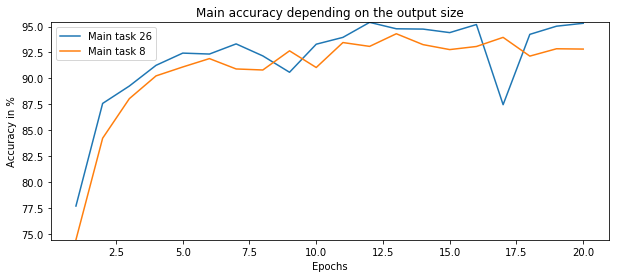

In [34]:
show_results(results, title="Main accuracy depending on the output size")

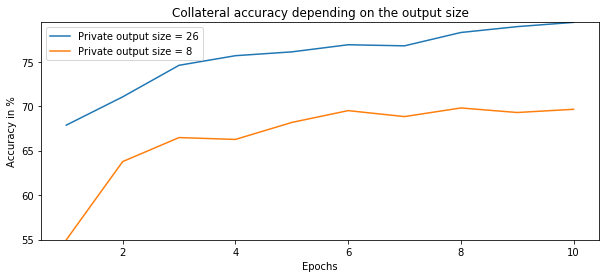

In [26]:
show_results(collateral_accuracy, title="Collateral accuracy depending on the output size")

The main accuracy has a 2% drop in accuracy while the collateral suffers from a 10% one!

## Conclusion

What we observe here is that the private output size is a key factor to resist against CNN collateral models. We will make an extended analysis of the private output size effects on non-CNN models in part 7 and show that this advantage is not always so clear, but first we'll implement fix precision!